# Satellite data 

This notebook loads Copernicus Marine daily L4 SST files (from `....ipynb`) and computes monthly SST anomalies, plus quick maps and a time series (2020-2024). (Might need to edit name opf the Copernicus SSt file)

Here I am looking at what satellite data says, I am considering at investigating SST, 


In [53]:
# 1) Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

from pathlib import Path

# SST
Here I am looking at intraannual SST spatiotemporal variability

In [54]:
ds = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-sst_glo_phy_nrt_l4_P1D-m_2021-2024.nc")
ds

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 1461, latitude: 300, longitude: 500)
Coordinates:
  * latitude      (latitude) float32 1kB 40.05 40.15 40.25 ... 69.75 69.85 69.95
  * longitude     (longitude) float32 2kB -59.95 -59.85 -59.75 ... -10.15 -10.05
  * time          (time) datetime64[ns] 12kB 2021-01-01 ... 2024-12-31
Data variables:
    analysed_sst  (time, latitude, longitude) float64 2GB ...
Attributes:
    contact:                   emmanuelle.autret@ifremer.fr;jfpiolle@ifremer.fr
    title:                     ODYSSEA Global Sea Surface Temperature Gridded...
    history:                   Optimally interpolated SST originally produced...
    institution:               Institut Francais de Recherche pour l'Exploita...
    Conventions:               CF-1.7, ACDD-1.3, ISO 8601
    source:                    Odyssea L4 processor
    references:                Product User Manual for L4 Odyssea Product ove...
    copernicusmarine_version:  2.2.1

In [55]:
sst =ds['analysed_sst']
sst = sst - 273.15  # Convert from Kelvin to Celsius
sst = sst.rename('degC')  # Rename variable for convenience

### Cropping of study location
Not needed as data downloaded to exact location

In [56]:
# Example: same bounds as downloader
lat_name = "lat" if "lat" in sst.dims else "latitude"
lon_name = "lon" if "lon" in sst.dims else "longitude"

# If your longitude is 0..360 and you want negatives, you can convert once:
# if sst[lon_name].max() > 180:
#     sst = sst.assign_coords({lon_name: (((sst[lon_name] + 180) % 360) - 180)}).sortby(lon_name)

sst = sst.sel({lat_name: slice(54, 67), lon_name: slice(-45, -10)})
sst

<xarray.DataArray 'degC' (time: 1461, latitude: 130, longitude: 350)> Size: 532MB
array([[[ 5.79,  5.86,  5.88, ...,  9.49,  9.49,  9.51],
        [ 5.54,  5.6 ,  5.63, ...,  9.56,  9.54,  9.53],
        [ 5.23,  5.28,  5.31, ...,  9.63,  9.57,   nan],
        ...,
        [  nan,   nan,   nan, ...,  2.66,  2.66,  2.65],
        [  nan,   nan,   nan, ...,  2.57,  2.56,  2.54],
        [  nan,   nan,   nan, ...,  2.44,  2.43,  2.42]],

       [[ 5.6 ,  5.68,  5.7 , ...,  9.42,  9.39,  9.41],
        [ 5.22,  5.33,  5.39, ...,  9.48,  9.44,  9.45],
        [ 4.93,  5.08,  5.19, ...,  9.58,  9.51,   nan],
        ...,
        [  nan,   nan,   nan, ...,  2.28,  2.27,  2.26],
        [  nan,   nan,   nan, ...,  2.22,  2.19,  2.15],
        [  nan,   nan,   nan, ...,  2.18,  2.14,  2.09]],

       [[ 5.29,  5.45,  5.51, ...,  9.38,  9.34,  9.35],
        [ 4.96,  5.13,  5.24, ...,  9.45,  9.41,  9.4 ],
        [ 4.7 ,  4.86,  4.98, ...,  9.52,  9.46,   nan],
        ...,
...
        [  nan,   nan,   nan, ...,  1.24,  1.33,  1.42],
        [  nan,   nan,   nan, ...,  1.21,  1.3 ,  1.41],
        [  nan,   nan,   nan, ...,  1.13,  1.18,  1.25]],

       [[ 5.29,  5.38,  5.46, ..., 10.39, 10.24, 10.17],
        [ 5.19,  5.28,  5.34, ..., 10.5 , 10.32, 10.19],
        [ 5.02,  5.09,  5.14, ..., 10.7 , 10.6 ,   nan],
        ...,
        [  nan,   nan,   nan, ...,  1.15,  1.24,  1.34],
        [  nan,   nan,   nan, ...,  1.1 ,  1.17,  1.28],
        [  nan,   nan,   nan, ...,  0.97,  1.03,  1.12]],

       [[ 5.28,  5.35,  5.39, ..., 10.44, 10.32, 10.25],
        [ 5.19,  5.25,  5.29, ..., 10.54, 10.41, 10.31],
        [ 5.08,  5.11,  5.13, ..., 10.69, 10.61,   nan],
        ...,
        [  nan,   nan,   nan, ...,  1.14,  1.24,  1.34],
        [  nan,   nan,   nan, ...,  1.03,  1.12,  1.22],
        [  nan,   nan,   nan, ...,  0.87,  0.91,  0.98]]],
      shape=(1461, 130, 350))
Coordinates:
  * latitude   (latitude) float32 520B 54.05 54.15 54.25 ... 66.75 66.85 66.95
  * longitude  (longitude) float32 1kB -44.95 -44.85 -44.75 ... -10.15 -10.05
  * time       (time) datetime64[ns] 12kB 2021-01-01 2021-01-02 ... 2024-12-31

### Calculating Monthly mean annomalies

In [57]:
# Monthly means, 12-month climatology, and seasonal anomalies
sst_mon = sst.resample(time='MS').mean()
clim12 = sst_mon.groupby('time.month').mean('time')           # (month, lat, lon)
annual_mean = clim12.mean('month')                             # (lat, lon)
seasonal_anom = clim12 - annual_mean                           # (month, lat, lon)

lon = sst[lon_name].values
lat = sst[lat_name].values

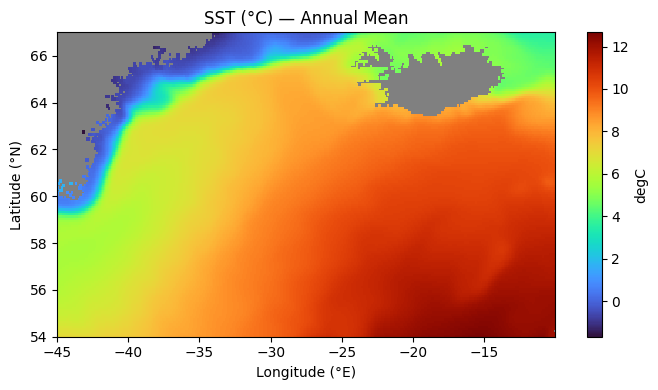

In [58]:
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolor(lon, lat, annual_mean.values, cmap='turbo')  # use cmocean.cm.thermal if available
plt.colorbar(cc, ax=ax, label='degC')
ax.set_title("SST (°C) — Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/756512561.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


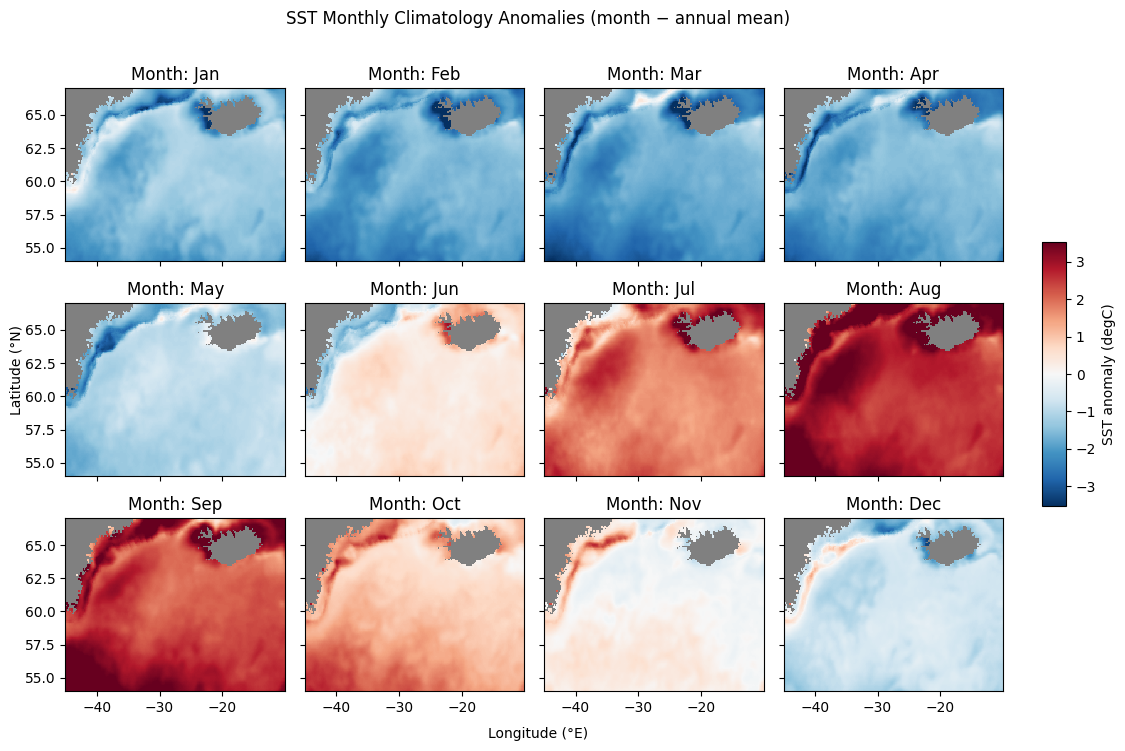

In [59]:
# Symmetric color scale using robust 98th percentile to avoid outliers
vlim = float(np.nanquantile(np.abs(seasonal_anom.values), 0.98))
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = seasonal_anom.isel(month=i).values
    cc_last = ax0.pcolor(lon, lat, da, cmap='RdBu_r', vmin=-vlim, vmax=+vlim)
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right, like the practical
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("SST anomaly (degC)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("SST Monthly Climatology Anomalies (month − annual mean)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()


# Chlorophyll 
Here a color estimated chlorophyll concentration data was used: https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/download?dataset=cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_202311

In [60]:
dc = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_2021-2024.nc")
dc
CHL = dc['CHL'] # Extracting Back scatter coefficient directly linked with chl concentrations
lat_name = "lat" if "lat" in CHL.dims else "latitude"
lon_name = "lon" if "lon" in CHL.dims else "longitude"

CHL = CHL.sel({lat_name: slice(54, 67), lon_name: slice(-45, -10)})

In [61]:
# Monthly means, 12-month climatology.
CHL_mon = CHL.resample(time='MS').mean()
CHL_clim12 = CHL_mon.groupby('time.month').mean('time')           # (month, lat, lon)
CHL_annual_mean = CHL_clim12.mean('month')                             # (lat, lon)

lon = CHL[lon_name].values
lat = CHL[lat_name].values

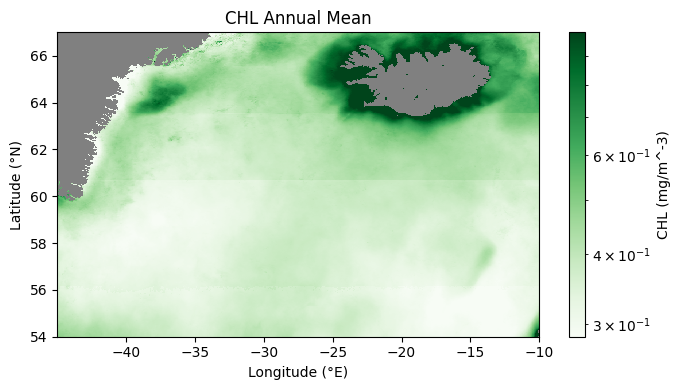

In [62]:
# Robust color scale for positive CHL values (log scale)
_vals = CHL_annual_mean.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_mean.values,
    cmap='Greens', norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL (mg/m^-3)')
ax.set_title("CHL Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/2562950514.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


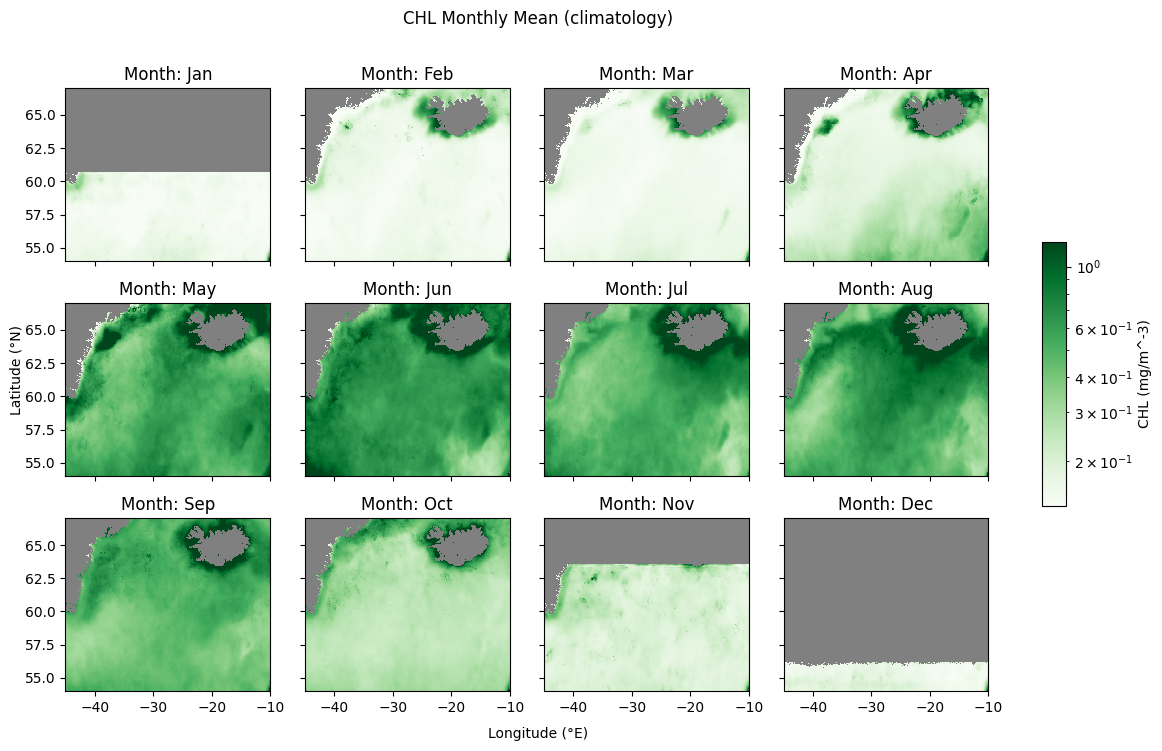

In [63]:
# Robust color scale for positive CHL values across all months (log scale)
_vals = CHL_clim12.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = CHL_clim12.isel(month=i).values
    cc_last = ax0.pcolormesh(
        lon, lat, da, cmap='Greens',
        norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
        shading='auto'
    )
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("CHL (mg/m^-3)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("CHL Monthly Mean (climatology)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()

/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: De

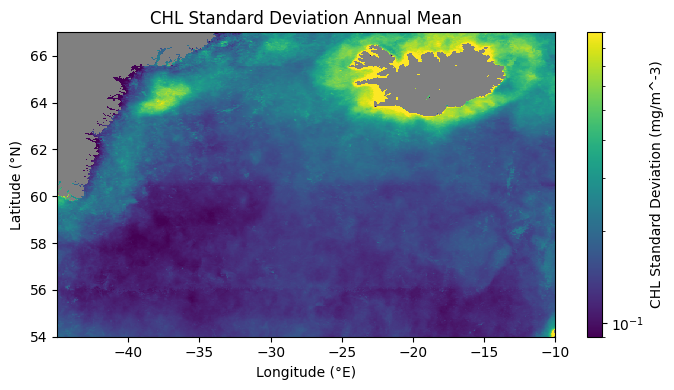

In [64]:
# Creating CHL standard Diviation for both Monthly and Annual
CHL_std = CHL.resample(time='MS').std()
CHL_annual_std = CHL_std.mean('time')  

#Plotting CHL Standard Deviation for both Monthly and Annual
_vals = CHL_annual_std.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = (0.09, 0.9)
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_std.values,
    norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL Standard Deviation (mg/m^-3)')
ax.set_title("CHL Standard Deviation Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show() 

## Bathymetry Data
Setting up bathymetry data within the region, Isolating data within -1500

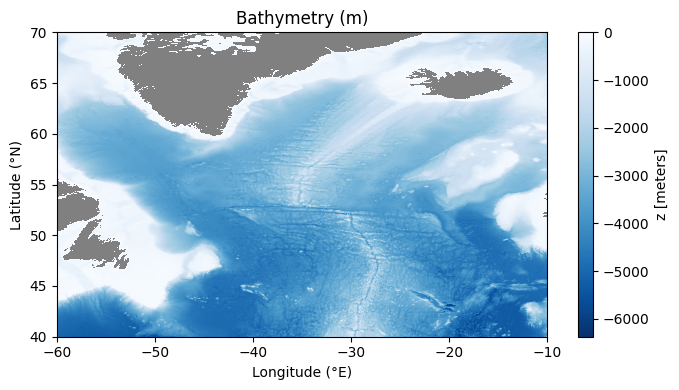

In [65]:
# Fetching BAthymetry Data

bathy = xr.open_dataset("../data/etopo1_subset.nc")

bathy = bathy.assign_coords(
    longitude=((bathy.longitude + 180) % 360) - 180
).sortby("longitude") # Convert from 0..360 to -180..180 if needed

bathy = bathy.where(bathy.z <= 0)  # Mask Surface areas

#PLoting Bathymetry
bathy.z.plot(figsize=(7,4), cmap='Blues_r')
plt.title("Bathymetry (m)")
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.gca().set_facecolor("gray")
plt.tight_layout()
plt.show()

In [66]:
bathy = bathy.sel(latitude=slice(54, 67), longitude=slice(-45, -10))

bathy_on_chl = bathy["z"].interp(
    longitude=CHL[lon_name],
    latitude=CHL[lat_name],
    method="linear",
)

# Isolating CHL using Bathymetry data in areas deeper than 1500m
CHL = CHL.where(bathy_on_chl < -1000)

In [67]:
# Monthly means, 12-month climatology.
CHL_mon = CHL.resample(time='MS').mean()
CHL_clim12 = CHL_mon.groupby('time.month').mean('time')           # (month, lat, lon)
CHL_annual_mean = CHL_clim12.mean('month')                             # (lat, lon)

lon = CHL[lon_name].values
lat = CHL[lat_name].values

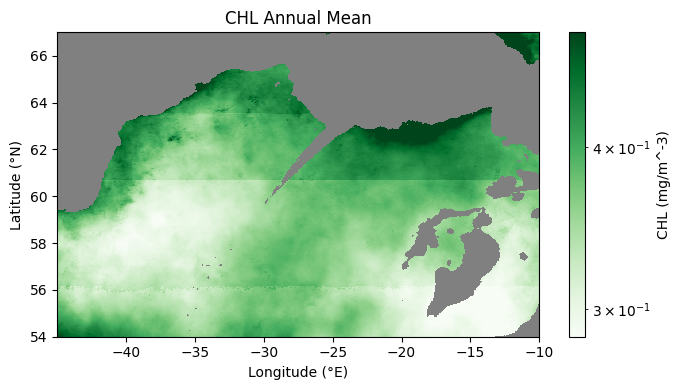

In [68]:
# Robust color scale for positive CHL values (log scale)
_vals = CHL_annual_mean.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_mean.values,
    cmap='Greens', norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL (mg/m^-3)')
ax.set_title("CHL Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/2562950514.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


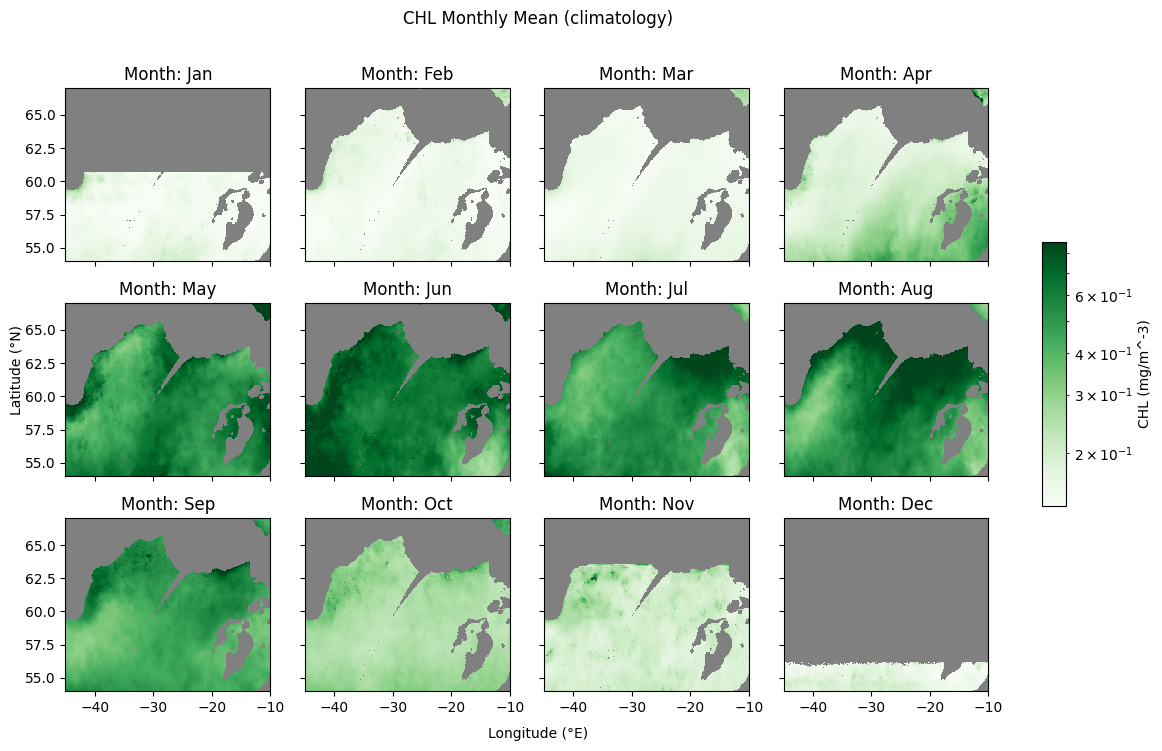

In [69]:
# Robust color scale for positive CHL values across all months (log scale)
_vals = CHL_clim12.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = CHL_clim12.isel(month=i).values
    cc_last = ax0.pcolormesh(
        lon, lat, da, cmap='Greens',
        norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
        shading='auto'
    )
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("CHL (mg/m^-3)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("CHL Monthly Mean (climatology)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()

### Standard Diviation Raster
Mappinstandard Diviation Mapping

In [ ]:
# Creating CHL standard Diviation for both Monthly and Annual
CHL_std = CHL.resample(time='MS').std()
CHL_annual_std = CHL_std.mean('time')  

#Plotting CHL Standard Deviation for both Monthly and Annual
_vals = CHL_annual_std.valuesx
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0, 0.8])
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_std.values,
    norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL Standard Deviation (mg/m^-3)')
ax.set_title("CHL Standard Deviation Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show() 


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: De

AttributeError: 'DataArray' object has no attribute 'valuesx'

: 

## Subdividing the region

Futher subdividing the region According to primeraly bathymetry, although I am looking into biogeochemical provences

In [ ]:
from shapely.geometry import Point, Polygon
import numpy as np

# Creating a matrice with the right cooridinates
LON, LAT = np.meshgrid(lon, lat)
print(LON.shape)
print(CHL.shape)

irminger = np.full(LON.shape, True)

# Vertices in (lon, lat) order
irminger_vertices = [
    (-44, 66),   # 1
    (-25, 66),   # 2
    (-25, 64),   # 3
    (-35, 55),   # 4
    (-44, 55)    # 5
]

irminger_poly = Polygon(irminger_vertices)

irminger = np.zeros_like(LON, dtype=bool)

for i in range(LON.shape[0]):
    for j in range(LON.shape[1]):
        irminger[i, j] = irminger_poly.contains(Point(LON[i, j], LAT[i, j]))

# Vertices in (lon, lat) order
icelandic_vertices = [
    (-25, 64),   # 1
    (-10, 64),   # 2
    (-20, 55),   # 3
    (-35, 55)   # 4
]

icelandic_poly = Polygon(icelandic_vertices)

icelandic = np.zeros_like(LON, dtype=bool)

for i in range(LON.shape[0]):
    for j in range(LON.shape[1]):
        icelandic[i, j] = icelandic_poly.contains(Point(LON[i, j], LAT[i, j]))

#Slicing Bathymetry to match CHL area
bathy = bathy.sel(latitude=slice(54, 67), longitude=slice(-45, -10))



(312, 840)
(4018, 312, 840)


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/2711064755.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/2711064755.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(LON, LAT, irminger, colors='blue', linewidths=1.5, linestyles='--', label='Irminger')
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/2711064755.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(LON, LAT, icelandic, colors='orange', linewidths=1.5, linestyles='--', label='Icelandic')
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/2711064755.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


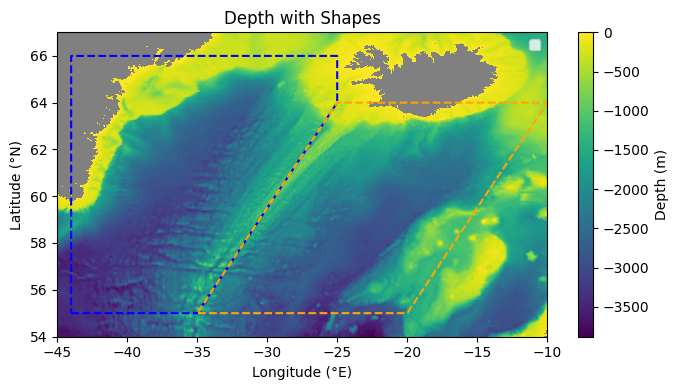

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/2711064755.py:37: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(LON, LAT, irminger, colors='blue', linewidths=1.5, linestyles='--', label='Irminger')
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_37077/2711064755.py:38: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(LON, LAT, icelandic, colors='orange', linewidths=1.5, linestyles='--', label='Icelandic')


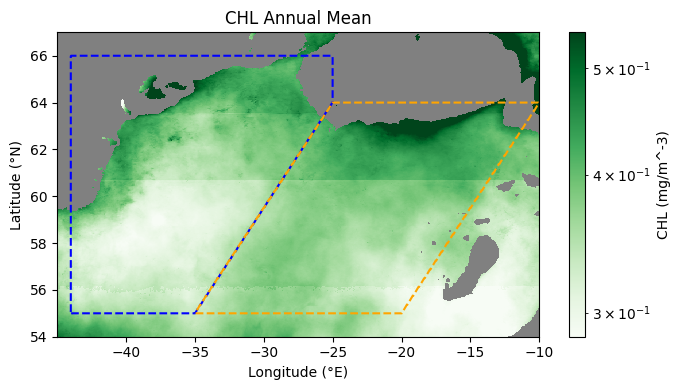

In [ ]:

# Plotting Bathymetry 
fig, ax = plt.subplots(figsize=(7,4))
cc = bathy.z.plot(ax=ax, x='longitude', y='latitude', add_colorbar=False)  # xarray handles coords
plt.colorbar(cc, ax=ax, label='Depth (m)')

ax.set_title("Depth with Shapes")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
ax.legend()

# Overlay your shapes (must match same coord system)
ax.contour(LON, LAT, irminger, colors='blue', linewidths=1.5, linestyles='--', label='Irminger')
ax.contour(LON, LAT, icelandic, colors='orange', linewidths=1.5, linestyles='--', label='Icelandic')

plt.tight_layout()
plt.show()

# Robust color scale for positive CHL values (log scale)
_vals = CHL_annual_mean.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])

fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_mean.values,
    cmap='Greens', norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL (mg/m^-3)')
ax.set_title("CHL Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")

# Adding Shapes to CHL graph for reference
ax.contour(LON, LAT, irminger, colors='blue', linewidths=1.5, linestyles='--', label='Irminger')
ax.contour(LON, LAT, icelandic, colors='orange', linewidths=1.5, linestyles='--', label='Icelandic')
plt.tight_layout()
plt.show()


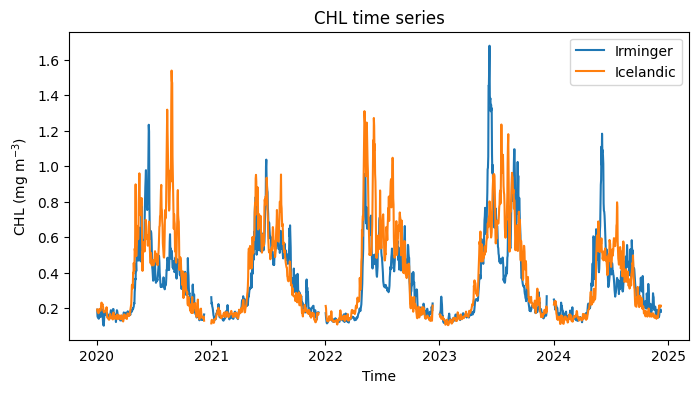

In [ ]:
# Selecting data within this square
irminger_CHL = CHL.where(irminger)
icelandic_CHL = CHL.where(icelandic)

# Averaging data for linear time series and Plotting it
irminger_ts = irminger_CHL.mean(dim=("latitude", "longitude"), skipna=True)
icelandic_ts = icelandic_CHL.mean(dim=("latitude", "longitude"), skipna=True)

# Creating a Figure with Matplot rather then xarray

# Limitng time series to post 2020 data, to see better detail
irminger_ts_post2020 = irminger_ts.sel(time=slice("2020-01-01", None))
icelandic_ts_post2020 = icelandic_ts.sel(time=slice("2020-01-01", None))


fig, ax = plt.subplots(figsize=(8, 4))

irminger_ts_post2020.plot(ax=ax, label="Irminger")
icelandic_ts_post2020.plot(ax=ax, label="Icelandic")

ax.set_title("CHL time series")
ax.set_xlabel("Time")
ax.set_ylabel("CHL (mg m$^{-3}$)")
ax.legend()
plt.show()


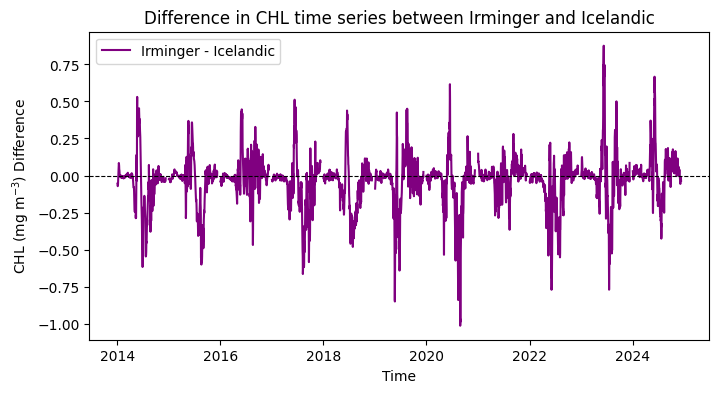

In [ ]:
Difference = irminger_ts - icelandic_ts



fig, ax = plt.subplots(figsize=(8, 4))

Difference.plot(ax=ax, color='purple', label="Irminger - Icelandic")
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
ax.set_title("Difference in CHL time series between Irminger and Icelandic")
ax.set_xlabel("Time")
ax.set_ylabel("CHL (mg m$^{-3}$) Difference")
ax.legend()
plt.show()

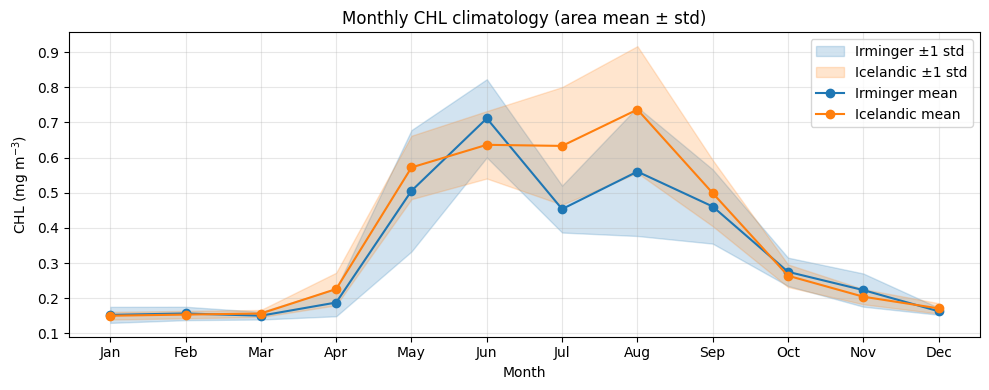

In [ ]:
# Monthly Shape Climatology with standard deviation envelopes
irminger_mon = irminger_CHL.resample(time='MS').mean()
irminger_clim12 = irminger_mon.groupby('time.month').mean('time')
irminger_area_mean = irminger_clim12.mean(dim=('latitude', 'longitude'), skipna=True)
irminger_area_std = irminger_clim12.std(dim=('latitude', 'longitude'), skipna=True)

icelandic_mon = icelandic_CHL.resample(time='MS').mean()
icelandic_clim12 = icelandic_mon.groupby('time.month').mean('time')
icelandic_area_mean = icelandic_clim12.mean(dim=('latitude', 'longitude'), skipna=True)
icelandic_area_std = icelandic_clim12.std(dim=('latitude', 'longitude'), skipna=True)

months_idx = irminger_area_mean['month'].values
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(10, 4))
irminger_color = 'tab:blue'
icelandic_color = 'tab:orange'

ax.fill_between(
    months_idx,
    (irminger_area_mean - irminger_area_std).values,
    (irminger_area_mean + irminger_area_std).values,
    color=irminger_color,
    alpha=0.2,
    label='Irminger ±1 std'
)
ax.fill_between(
    months_idx,
    (icelandic_area_mean - icelandic_area_std).values,
    (icelandic_area_mean + icelandic_area_std).values,
    color=icelandic_color,
    alpha=0.2,
    label='Icelandic ±1 std'
)

ax.plot(months_idx, irminger_area_mean.values, marker='o', color=irminger_color, label='Irminger mean')
ax.plot(months_idx, icelandic_area_mean.values, marker='o', color=icelandic_color, label='Icelandic mean')

ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(months_labels)
ax.set_xlabel('Month')
ax.set_ylabel('CHL (mg m$^{-3}$)')
ax.set_title('Monthly CHL climatology (area mean ± std)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/xarray/core/dataset_utils.py:86: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/xarray/core/dataset_utils.py:86: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


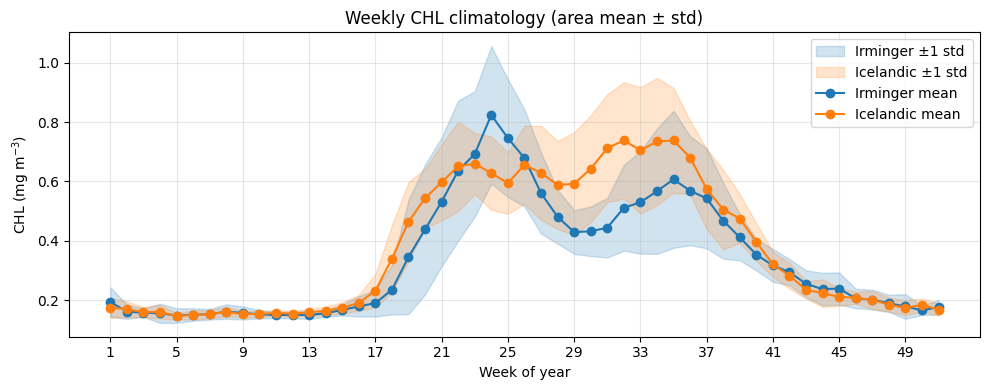

In [ ]:
# Weekly Shape Climatology with standard deviation envelopes (starting at Monday)
irminger_wk = irminger_CHL.resample(time='W-MON').mean()
icelandic_wk = icelandic_CHL.resample(time='W-MON').mean()

irminger_clim52 = irminger_wk.groupby('time.week').mean('time')
icelandic_clim52 = icelandic_wk.groupby('time.week').mean('time')

irminger_area_mean = irminger_clim52.mean(dim=('latitude', 'longitude'), skipna=True)
icelandic_area_mean = icelandic_clim52.mean(dim=('latitude', 'longitude'), skipna=True)
irminger_area_std = irminger_clim52.std(dim=('latitude', 'longitude'), skipna=True)
icelandic_area_std = icelandic_clim52.std(dim=('latitude', 'longitude'), skipna=True)

weeks_idx = irminger_area_mean['week'].values

fig, ax = plt.subplots(figsize=(10, 4))
irminger_color = 'tab:blue'
icelandic_color = 'tab:orange'

ax.fill_between(
    weeks_idx,
    (irminger_area_mean - irminger_area_std).values,
    (irminger_area_mean + irminger_area_std).values,
    color=irminger_color,
    alpha=0.2,
    label='Irminger ±1 std'
)
ax.fill_between(
    weeks_idx,
    (icelandic_area_mean - icelandic_area_std).values,
    (icelandic_area_mean + icelandic_area_std).values,
    color=icelandic_color,
    alpha=0.2,
    label='Icelandic ±1 std'
)

ax.plot(weeks_idx, irminger_area_mean.values, marker='o', color=irminger_color, label='Irminger mean')
ax.plot(weeks_idx, icelandic_area_mean.values, marker='o', color=icelandic_color, label='Icelandic mean')

ax.set_title('Weekly CHL climatology (area mean ± std)')
ax.set_xlabel('Week of year')
ax.set_ylabel('CHL (mg m$^{-3}$)')
ax.set_xticks(np.arange(1, 53, 4))
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


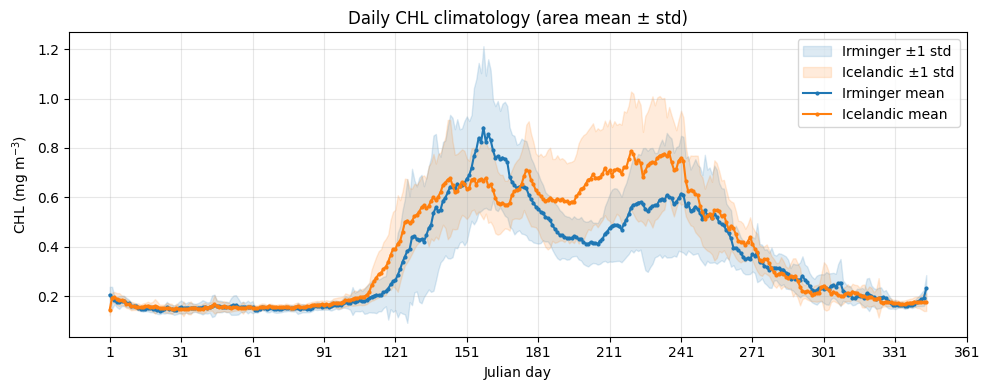

In [ ]:
# Daily Shape Climatology with standard deviation envelopes (starting at Monday)
irminger_D = irminger_CHL.resample(time='1D').mean()
icelandic_D = icelandic_CHL.resample(time='1D').mean()

irminger_day = irminger_D.assign_coords(doy=irminger_D['time'].dt.dayofyear)
icelandic_day = icelandic_D.assign_coords(doy=icelandic_D['time'].dt.dayofyear)

irminger_clim365 = irminger_day.groupby('doy').mean('time')
icelandic_clim365 = icelandic_day.groupby('doy').mean('time')

irminger_area_mean = irminger_clim365.mean(dim=('latitude', 'longitude'), skipna=True)
icelandic_area_mean = icelandic_clim365.mean(dim=('latitude', 'longitude'), skipna=True)
irminger_area_std = irminger_clim365.std(dim=('latitude', 'longitude'), skipna=True)
icelandic_area_std = icelandic_clim365.std(dim=('latitude', 'longitude'), skipna=True)

doy_idx = irminger_area_mean['doy'].values

fig, ax = plt.subplots(figsize=(10, 4))
irminger_color = 'tab:blue'
icelandic_color = 'tab:orange'

ax.fill_between(
    doy_idx,
    (irminger_area_mean - irminger_area_std).values,
    (irminger_area_mean + irminger_area_std).values,
    color=irminger_color,
    alpha=0.15,
    label='Irminger ±1 std'
)
ax.fill_between(
    doy_idx,
    (icelandic_area_mean - icelandic_area_std).values,
    (icelandic_area_mean + icelandic_area_std).values,
    color=icelandic_color,
    alpha=0.15,
    label='Icelandic ±1 std'
)

ax.plot(doy_idx, irminger_area_mean.values, marker='o', markersize=2, color=irminger_color, label='Irminger mean')
ax.plot(doy_idx, icelandic_area_mean.values, marker='o', markersize=2, color=icelandic_color, label='Icelandic mean')

ax.set_title('Daily CHL climatology (area mean ± std)')
ax.set_xlabel('Julian day')
ax.set_ylabel('CHL (mg m$^{-3}$)')
ax.set_xticks(np.arange(1, 367, 30))
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


# Estimating Euphotic depth 
 Here we estimate Zeu for both regiosn using satellite surfae CHL vales and the Morel and Berthon (1989) empirical relationship:
Zeu = 10^(0.293 - 0.589*log10(CHL))
where Zeu is the euphotic depth in meters and CHL is the chlorophyll concentration in mg/m^3. 

In [ ]:
# Estimating Euphotic depth for each shape

# Using power-law form directly (simplest)
irminger_Zeu = 34 * irminger_CHL**(-0.39)
icelandic_Zeu = 34 * icelandic_CHL**(-0.39)

# Or, if you really want the log10 form:
irminger_Zeu = 10**(np.log10(34) - 0.39 * np.log10(irminger_CHL))
icelandic_Zeu = 10**(np.log10(34) - 0.39 * np.log10(icelandic_CHL))

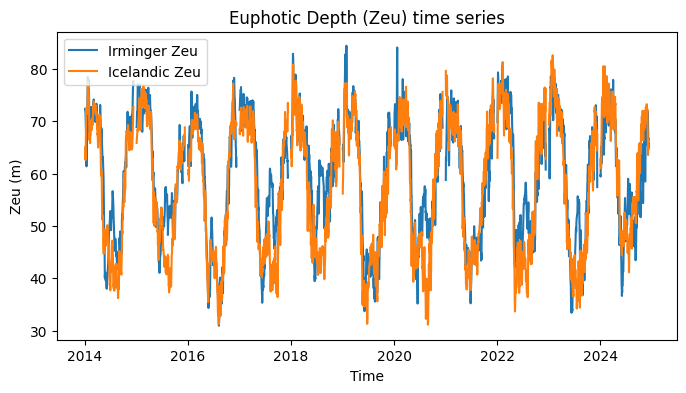

In [ ]:
# Plotting timeseries of Zeu for both shapes
irminger_Zeu_ts = irminger_Zeu.mean(dim=("latitude", "longitude"), skipna=True)
icelandic_Zeu_ts = icelandic_Zeu.mean(dim=("latitude", "longitude"), skipna=True)

fig, ax = plt.subplots(figsize=(8, 4))
irminger_Zeu_ts.plot(ax=ax, label="Irminger Zeu")
icelandic_Zeu_ts.plot(ax=ax, label="Icelandic Zeu")
ax.set_title("Euphotic Depth (Zeu) time series")
ax.set_xlabel("Time")
ax.set_ylabel("Zeu (m)")
ax.legend()
plt.show()

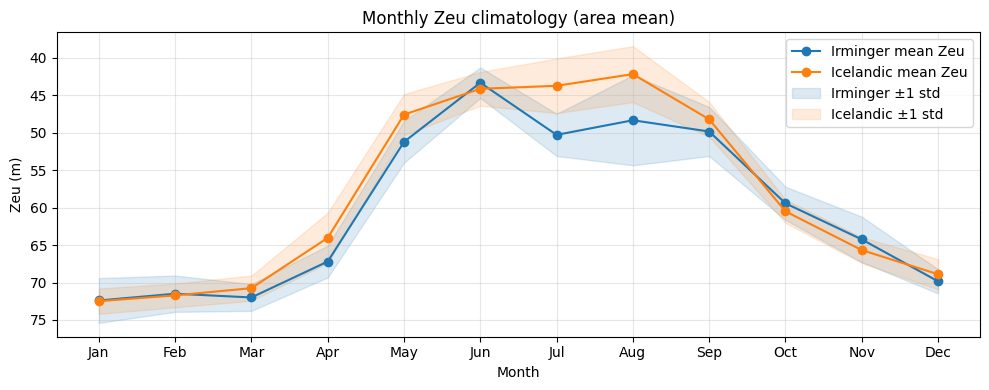

In [ ]:
# Monthly climatology (month, lat, lon)
irminger_Zeu_mon = irminger_Zeu.resample(time='MS').mean()
irminger_Zeu_clim12 = irminger_Zeu_mon.groupby('time.month').mean('time')

icelandic_Zeu_mon = icelandic_Zeu.resample(time='MS').mean()
icelandic_Zeu_clim12 = icelandic_Zeu_mon.groupby('time.month').mean('time')

# Area-mean monthly climatology  -> now dimension is just 'month'
irminger_Zeu_clim_area = irminger_Zeu_clim12.mean(dim=('latitude', 'longitude'), skipna=True)
icelandic_Zeu_clim_area = icelandic_Zeu_clim12.mean(dim=('latitude', 'longitude'), skipna=True)

# Standard Deviation for both shapes
irminger_Zeu_clim_std = irminger_Zeu_clim12.std(dim=('latitude', 'longitude'), skipna=True)
icelandic_Zeu_clim_std = icelandic_Zeu_clim12.std(dim=('latitude', 'longitude'), skipna=True)

months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(10, 4))
#Plorring Values

ax.plot(months_labels,
        irminger_Zeu_clim_area.values,
        marker='o', label='Irminger mean Zeu')

ax.plot(months_labels,
        icelandic_Zeu_clim_area.values,
        marker='o', label='Icelandic mean Zeu')

# PLotting standard Deviation envelopes
ax.fill_between(
    months_labels,
    (irminger_Zeu_clim_area - irminger_Zeu_clim_std).values,
    (irminger_Zeu_clim_area + irminger_Zeu_clim_std).values,
    color=irminger_color,
    alpha=0.15,
    label='Irminger ±1 std'
)
ax.fill_between(
    months_labels,
    (icelandic_Zeu_clim_area - icelandic_Zeu_clim_std).values,
    (icelandic_Zeu_clim_area + icelandic_Zeu_clim_std).values,
    color=icelandic_color,
    alpha=0.15,
    label='Icelandic ±1 std'
)

ax.set_title('Monthly Zeu climatology (area mean)')
ax.set_xlabel('Month')
ax.set_ylabel('Zeu (m)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Plotting with Argo MLD

clim1_m = pd.read_parquet('../data/argo/Region/irminger_MLD_Climatology.parquet')
clim2_m = pd.read_parquet('../data/argo/Region/icelandic_MLD_Climatology.parquet')

# Define colours for clarity
irminger_color = "tab:green"
irminger_mld_color = "tab:brown"

icelandic_color = "#98FB98"
icelandic_mld_color = "#CD853F"

# ---- Irminger ----
fig, ax = plt.subplots(figsize=(10, 4))

# Zeu (mean)
ax.plot(
    months_labels,
    irminger_Zeu_clim_area.values,
    marker='o',
    color=irminger_color,
    label='Irminger mean Zeu'
)

# MLD (mean)
ax.plot(
    months_labels,
    clim1_m['MLD_mean'].values,
    marker='s',
    color=irminger_mld_color,
    label='Irminger mean MLD (Argo)'
)

# Zeu ±1 std shading
ax.fill_between(
    months_labels,
    (irminger_Zeu_clim_area - irminger_Zeu_clim_std).values,
    (irminger_Zeu_clim_area + irminger_Zeu_clim_std).values,
    color=irminger_color,
    alpha=0.15,
    label='Irminger Zeu ±1 std'
)

# MLD IQR shading
ax.fill_between(
    months_labels,
    clim1_m["MLD_p25"],
    clim1_m["MLD_p75"],
    color=irminger_mld_color,
    alpha=0.2,
    label='Irminger MLD (25–75%)'
)

ax.set_title('Monthly Zeu vs MLD Climatology — Irminger')
ax.set_xlabel('Month')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()



# ---- Icelandic ----
fig, ax = plt.subplots(figsize=(10, 4))

# Zeu (mean)
ax.plot(
    months_labels,
    icelandic_Zeu_clim_area.values,
    marker='o',
    color=icelandic_color,
    label='Icelandic mean Zeu'
)

# MLD (mean)
ax.plot(
    months_labels,
    clim2_m['MLD_mean'].values,
    marker='s',
    color=icelandic_mld_color,
    label='Icelandic mean MLD (Argo)'
)

# Zeu ±1 std shading
ax.fill_between(
    months_labels,
    (icelandic_Zeu_clim_area - icelandic_Zeu_clim_std).values,
    (icelandic_Zeu_clim_area + icelandic_Zeu_clim_std).values,
    color=icelandic_color,
    alpha=0.15,
    label='Icelandic Zeu ±1 std'
)

# MLD IQR shading
ax.fill_between(
    months_labels,
    clim2_m["MLD_p25"],
    clim2_m["MLD_p75"],
    color=icelandic_mld_color,
    alpha=0.2,
    label='Icelandic MLD (25–75%)'
)

ax.set_title('Monthly Zeu vs MLD Climatology — Icelandic')
ax.set_xlabel('Month')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../data/argo/Region/irminger_MLD_Climatology.parquet'

# Bloom timing
For further analysis look at Buendena et al 2025 for methodology, (they have bloom initiations via climatology) 